In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers
import sys
import os
import time
import random

In [2]:
scriptpath = "../scripts/"

# Add the directory containing your module to the Python path (wants absolute paths)
sys.path.append(os.path.abspath(scriptpath))

In [3]:
sys.path

['/home/ragou/repo/github/RAPMC/notebook',
 '',
 '/home/ragou/.local/lib/python3.8/site-packages',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.8/dist-packages',
 '/home/ragou/.local/lib/python3.8/site-packages/IPython/extensions',
 '/home/ragou/.ipython',
 '/home/ragou/repo/github/RAPMC/scripts']

In [5]:
!chmod 775 ../scripts/article_cleaner.py
import article_cleaner

# Load test data

In [6]:
test_variant = "../../data/test_variants/test_variants"
test_text = "../../data/test_text/test_text"

In [7]:
dtf_text = pd.read_csv(test_text, sep = "\|\|")

/home/ragou/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [8]:
dtf_text.columns = ["Text"]
dtf_text.index.name = "ID"

In [9]:
dtf_text

,Text
ID,
0,2. This mutation resulted in a myeloproliferat...
1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,Vascular endothelial growth factor receptor (V...
3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,Abstract Retinoblastoma is a pediatric retina...
...,...
5663,The realization in the late 1970s that RAS har...
5664,Hemizygous deletions are common molecular abno...
5665,All most R267W of has with to SMARTpool invest...


In [9]:
dtf_var = pd.read_csv(test_variant)

In [11]:
dtf_var

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A
...,...,...,...
5663,5663,SLC46A1,R113S
5664,5664,FOXC1,L130F
5665,5665,GSS,R267W
5666,5666,CTSK,G79E


In [10]:
dtf_concat = pd.merge(dtf_var, dtf_text, on = "ID").dropna()

In [62]:
dtf_concat["Gene"]

0         ACSL4
1         NAGLU
2           PAH
3          ING1
4       TMEM216
         ...   
5663    SLC46A1
5664      FOXC1
5665        GSS
5666       CTSK
5667     DFNB59
Name: Gene, Length: 5667, dtype: object

In [63]:
start = time.time()
clean_test = dtf_concat.apply(lambda line : article_cleaner.extract_match(line), axis = 1)
print(time.time() - start)

1634316914.2424853


In [66]:
clean_match = pd.DataFrame(list(clean_test), columns = ["Text","Score"], index = clean_test.index)
clean_match.to_csv("../datas/sub_test_clean.txt", index=False)

In [67]:
clean_match

,Text,Score
0,mutant jak2 transfected into murine bone marr...,1
1,go to: introduction lats1 (large tumor suppr...,1
2,vegfr2 is a transmembrane receptor tyrosine k...,1
3,imts are diagnosed pathologically using crit...,1
4,systemic carboplatin treatment has been assoc...,1
...,...,...
5663,serving as transducers that couple cell surfa...,1
5664,"in other cases, hemizygous deletions cause di...",1
5665,all most r267w of has with to smartpool inves...,1
5666,blood samples have been obtained from affecte...,1


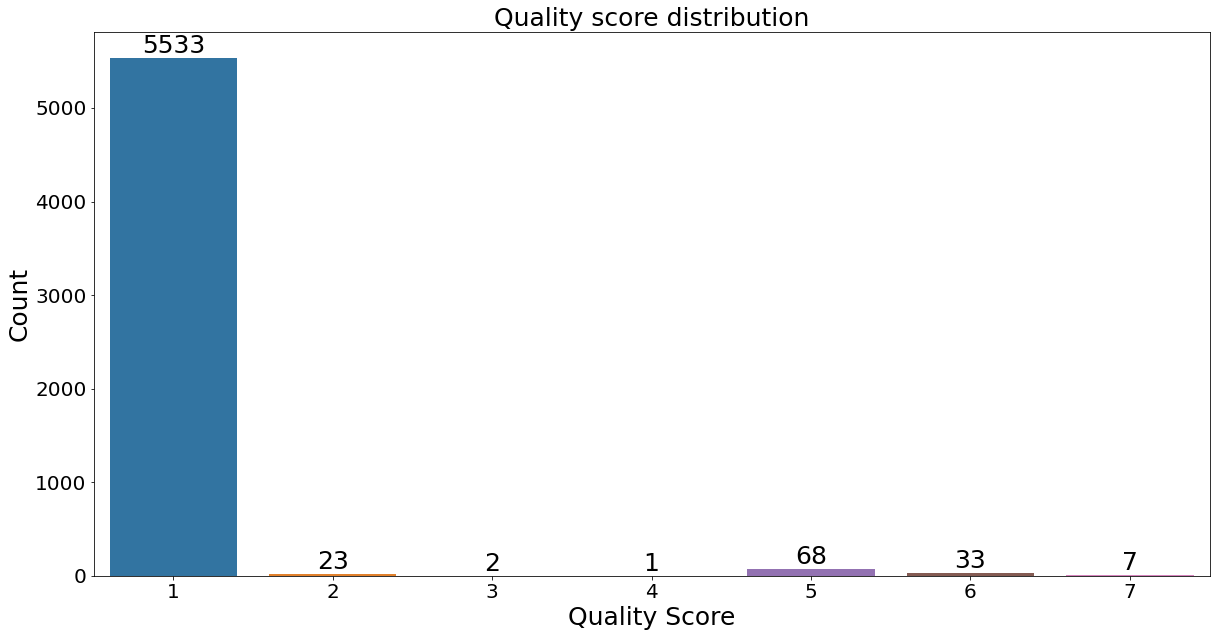

In [68]:
plt.figure(figsize=(20,10))
g = sns.countplot(x = clean_match["Score"])
plt.title("Quality score distribution", fontsize = 25)
g.bar_label(g.containers[0], fontsize = 25)

plt.xlabel("Quality Score",fontsize = 25)
plt.ylabel("Count",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [69]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")


def pre_processing(data):
    # lowercase text
    data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
#     # remove numeric values
#     data = data.str.replace("\d","")
#     # remove punctuations
#     data = data.str.replace("[^\w\s]","")
    # remove stopwords: the,a,an etc.
    data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
    return data


[nltk_data] Downloading package stopwords to /home/ragou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
clean_test_text = pre_processing(clean_match["Text"])

In [75]:
# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 2000 
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(clean_test_text) # Updates internal vocabulary based on a list of texts.
# Pad the data 
X = tokenizer.texts_to_sequences(clean_test_text) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=2000) # transforms a lists of integers into a 2D Numpy array of shape

In [74]:
X

NameError: name 'X' is not defined

In [ ]:
Y_D = pd.get_dummies(dtf['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, random_state = 42, stratify=Y_D)
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

# Load model CNN

In [72]:
model = keras.models.load_model('model_cnn.h5')

In [73]:
model.weights

[<tf.Variable 'embedding_28/embeddings:0' shape=(2000, 128) dtype=float32, numpy=
 array([[-0.01194105, -0.00893595, -0.09128901, ..., -0.01825847,
          0.00260322, -0.0536463 ],
        [ 0.14629889,  0.0564375 , -0.11996924, ...,  0.0667411 ,
          0.11231963, -0.11683479],
        [ 0.04504862,  0.1216522 ,  0.08654026, ...,  0.07509339,
          0.0276182 , -0.08756479],
        ...,
        [ 0.07698343, -0.00126461, -0.03485166, ..., -0.09692236,
         -0.01976166, -0.05523314],
        [-0.03065643,  0.04007576,  0.00551316, ..., -0.02421315,
         -0.09088104,  0.05043201],
        [ 0.04888308, -0.00193551, -0.00225104, ...,  0.00101527,
          0.01284167,  0.03524701]], dtype=float32)>,
 <tf.Variable 'conv1d_48/kernel:0' shape=(5, 128, 124) dtype=float32, numpy=
 array([[[ 0.11764958,  0.05362569, -0.04365219, ..., -0.07531936,
          -0.05758185, -0.01075119],
         [ 0.06658083, -0.06791958,  0.08262946, ..., -0.14793019,
          -0.04753087, -0.0

In [76]:
pred = model.predict(X)

In [77]:
pred

array([[0.08592225, 0.61625487, 0.05034164, ..., 0.14562257, 0.0139506 ,
        0.01022086],
       [0.00760226, 0.15426151, 0.00751455, ..., 0.7803706 , 0.01601127,
        0.01952733],
       [0.06376852, 0.29394072, 0.05998202, ..., 0.37470987, 0.05275764,
        0.02546156],
       ...,
       [0.2557722 , 0.12533906, 0.03574053, ..., 0.22894664, 0.04803827,
        0.05485355],
       [0.02193727, 0.16131398, 0.02547021, ..., 0.69062257, 0.03561165,
        0.01823783],
       [0.13134249, 0.47694322, 0.08207571, ..., 0.11278785, 0.03310905,
        0.01766418]], dtype=float32)

In [83]:
pred_class = []
final_pred = []
for n in range(len(pred)):
    temp = np.zeros(9)
    max_arg = np.argmax(pred[n], axis=0)
    max_arg = random.randint(0,8)
    pred_class.append(max_arg+1)
    temp[max_arg] = 1
    final_pred.append(temp)


In [84]:
final_pred

[array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0.

In [85]:
all_pred = pd.DataFrame(final_pred, columns = ["class1","class2","class3","class4","class5","class6","class7","class8","class9"])
all_pred = all_pred.astype(int)

In [86]:
all_pred.head(986)

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
981,1,0,0,0,0,0,0,0,0
982,0,1,0,0,0,0,0,0,0
983,1,0,0,0,0,0,0,0,0
984,0,0,0,0,0,0,1,0,0


In [90]:
new_class_id = pd.concat([dtf_concat["ID"].head(987),all_pred.head(987)], axis = 1)
new_class_id.drop([0]).to_csv("../datas/submission_random.csv", index = False)

In [88]:
new_class_id

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1
2,2,1,0,0,0,0,0,0,0,0
3,3,0,0,1,0,0,0,0,0,0
4,4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
982,982,0,1,0,0,0,0,0,0,0
983,983,1,0,0,0,0,0,0,0,0
984,984,0,0,0,0,0,0,1,0,0
985,985,0,0,0,0,1,0,0,0,0


In [71]:
dtf_concat.index = list(range(len(dtf_concat)))

In [63]:
new_class = pd.DataFrame(pred_class, columns=["Class"])
new_class

,Class
0,2
1,7
2,7
3,7
4,7
...,...
5662,7
5663,7
5664,1
5665,7


In [72]:
dtf_concat["ID"]

0          0
1          1
2          2
3          3
4          4
        ... 
5662    5663
5663    5664
5664    5665
5665    5666
5666    5667
Name: ID, Length: 5667, dtype: int64

In [92]:
new_class_id = pd.concat([dtf_concat["ID"],new_class], axis = 1)
new_class_id

,ID,Class
0,0,2
1,1,7
2,2,7
3,3,7
4,4,7
...,...,...
5662,5663,7
5663,5664,7
5664,5665,1
5665,5666,7


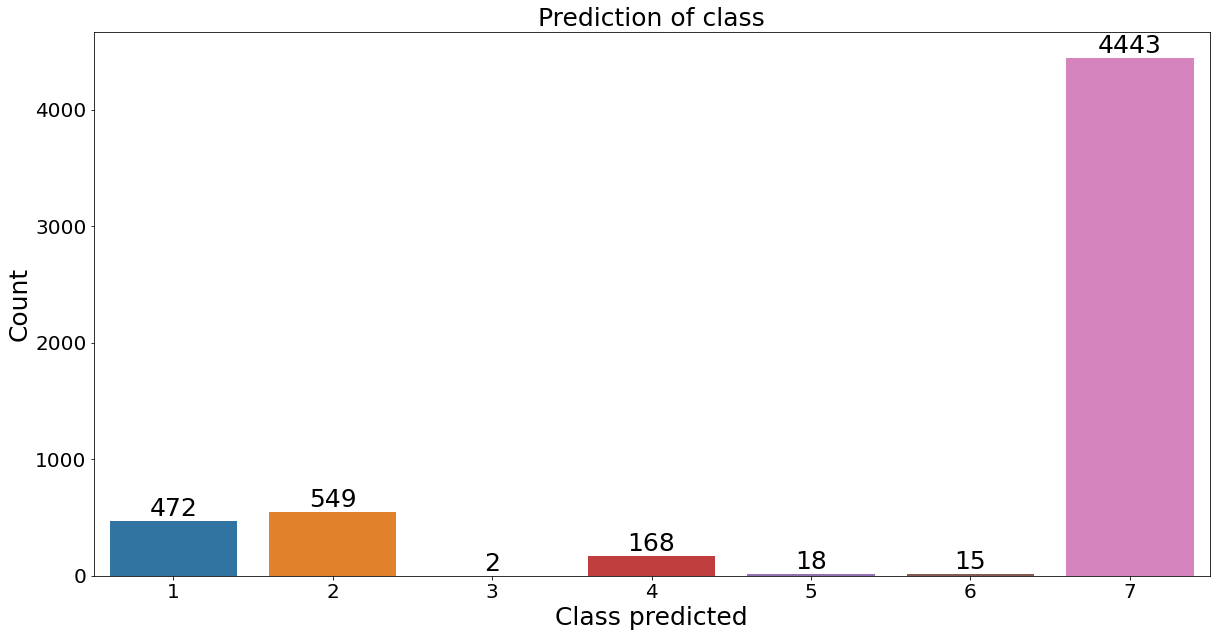

In [187]:
plt.figure(figsize=(20,10))
g = sns.countplot(x = new_class["Class"])
plt.title("Prediction of class", fontsize = 25)
g.bar_label(g.containers[0], fontsize = 25)

plt.xlabel("Class predicted",fontsize = 25)
plt.ylabel("Count",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()